# IMD metric robustness to Gaussian Blur

In [1]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.3 MB/s eta 0:00:00


In [56]:
import random
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
import piq



torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [57]:
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

transform_mnist = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

transform_cifar = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mnist_dataset = MNIST(root='MNIST/raw/train-images-idx3-ubyte',train=False, download=True, transform=transform_mnist)
cifar_dataset = CIFAR10(root='cifar-10-batches-py', train=False, download=True, transform=transform_cifar)

Files already downloaded and verified


In [58]:
len(mnist_dataset), len(cifar_dataset)

(10000, 10000)

In [59]:
from torchvision.models import vgg16, VGG16_Weights

class VGG16_FeaturesExtractor(torch.nn.Module):
    def __init__(self, weights=VGG16_Weights.DEFAULT):
        super().__init__()

        self.feature_extractor = vgg16(weights=VGG16_Weights.DEFAULT).features
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, x):
        output = []

        x = self.feature_extractor(x)
        x = self.avgpool(x).squeeze()
        output.append(x)

        return output

In [60]:
from collections import defaultdict

def collator_mnist(batch):
  batch_dict = defaultdict(list)
  for item in batch:
      batch_dict['images'].append(torch.concatenate((item[0], item[0], item[0]), axis=0).unsqueeze(0))
      batch_dict['targets'].append(torch.tensor(item[1]).unsqueeze(0))

  return {'images': torch.concatenate(batch_dict['images'], axis=0), 'targets': torch.concatenate(batch_dict['targets'], axis=0)}

def collator_cifar(batch):
  batch_dict = defaultdict(list)
  for item in batch:
      batch_dict['images'].append((item[0]).unsqueeze(0))
      batch_dict['targets'].append(torch.tensor(item[1]).unsqueeze(0))

  return {'images': torch.concatenate(batch_dict['images'], axis=0), 'targets': torch.concatenate(batch_dict['targets'], axis=0)}

mnist_dataloader = DataLoader(mnist_dataset, shuffle=False, batch_size=128, collate_fn=collator_mnist)
cifar_dataloader = DataLoader(cifar_dataset, shuffle=False, batch_size=128, collate_fn=collator_cifar)
mnist_features = piq.FID().compute_feats(mnist_dataloader, device='cuda', feature_extractor=VGG16_FeaturesExtractor())
cifar_features = piq.FID().compute_feats(cifar_dataloader, device='cuda', feature_extractor=VGG16_FeaturesExtractor())

In [62]:
from tqdm.notebook import tqdm

FID_MNIST_CIFAR = piq.FID()(mnist_features, cifar_features)
KID_MNIST_CIFAR = piq.KID()(mnist_features, cifar_features)
msid_cifar_mnist = []

num_samples = 10
for _ in tqdm(range(num_samples)):
  msid_cifar_mnist.append(piq.MSID(niters=100)(mnist_features, cifar_features))

MEAN_MSID_MNIST_CIFAR = np.mean(msid_cifar_mnist)
STD_MSID_MNIST_CIFAR = np.std(msid_cifar_mnist)

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
MEAN_MSID_MNIST_CIFAR, STD_MSID_MNIST_CIFAR

(79.5989953297037, 1.1027516896753224)

In [68]:
msid_cifar_mean = []
msid_cifar_std = []
fid_cifar = []
kid_cifar = []
num_sigmas = 10
sigmas = np.linspace(0, 3, num_sigmas)
num_samples = 10

for sigma in tqdm(sigmas):
  if sigma > 0:
    blur_transform = T.Compose([T.GaussianBlur(kernel_size=5, sigma=sigma), transform_cifar])
    cifar_dataset = CIFAR10(root='cifar-10-batches-py', train=False, download=True, transform=blur_transform)
    cifar_dataloader = DataLoader(cifar_dataset, shuffle=False, batch_size=128, collate_fn=collator_cifar)
    blurred_cifar_features = piq.FID().compute_feats(cifar_dataloader, device='cuda', feature_extractor=VGG16_FeaturesExtractor())

    msid_cifar_iter = []
    for _ in tqdm(range(num_samples)):
      msid_cifar_iter.append(piq.MSID(niters=100)(blurred_cifar_features, cifar_features))

    msid_cifar_mean.append(np.mean(msid_cifar_iter))
    msid_cifar_std.append(np.std(msid_cifar_iter))
    fid_cifar.append(piq.FID()(blurred_cifar_features, cifar_features))
    kid_cifar.append(piq.KID()(blurred_cifar_features, cifar_features))

  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
msid_cifar_iter = []
for _ in tqdm(range(num_samples)):
  msid_cifar_iter.append(piq.MSID(niters=100)(cifar_features, cifar_features))

msid_cifar_mean.insert(0, np.mean(msid_cifar_iter))
msid_cifar_std.insert(0, np.std(msid_cifar_iter))
fid_cifar.insert(0, piq.FID()(cifar_features, cifar_features))
kid_cifar.insert(0, piq.KID()(cifar_features, cifar_features))

  0%|          | 0/10 [00:00<?, ?it/s]

In [77]:
msid_cifar_mean = np.array(msid_cifar_mean)
msid_cifar_std = np.array( msid_cifar_std)
fid_cifar = np.array(fid_cifar)
kid_cifar = np.array(kid_cifar)

In [94]:
import matplotlib_inline

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

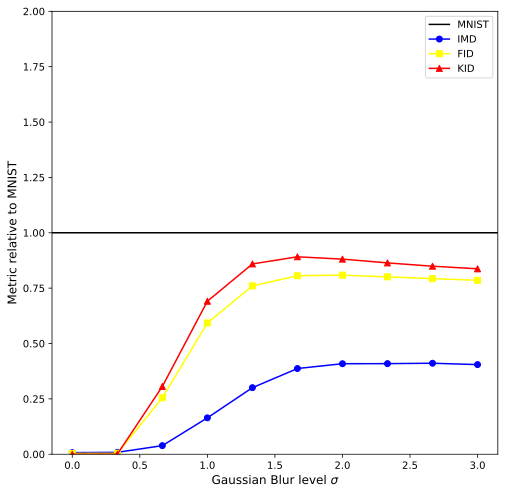

<Figure size 640x480 with 0 Axes>

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.axhline(y = 1.0, color = 'black', linestyle = '-', label='MNIST')
plt.plot(sigmas, msid_cifar_mean / MEAN_MSID_MNIST_CIFAR, color='blue', label='IMD', marker='o')
plt.plot(sigmas, fid_cifar / FID_MNIST_CIFAR, color='yellow', label='FID', marker='s')
plt.plot(sigmas, kid_cifar / KID_MNIST_CIFAR, color='red', label='KID', marker='^')
plt.legend()
plt.ylabel('Metric relative to MNIST', size=12)
plt.xlabel(r"Gaussian Blur level $\sigma$", size=12)
plt.ylim([0, 2])

plt.show()

In [124]:
np.linspace(1, 256, 10, dtype=int)

array([  1,  29,  57,  86, 114, 142, 171, 199, 227, 256])

In [125]:
from piq.msid import _msid_descriptor

t_arr = np.linspace(1, 256, 10, dtype=int)
features = [mnist_features, cifar_features]
mnist_hkt = []
cifar_hkt = []


for f, arr in tqdm(zip(features, [mnist_hkt, cifar_hkt])):
  for t in tqdm(t_arr):

    hkt_G = _msid_descriptor(f.detach().cpu().numpy(), ts=np.logspace(-1, 1, t), normalize='er')
    arr.append(hkt_G)

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [126]:
NORMALIZE = 1e6

for i in range(len(cifar_hkt)):
  cifar_hkt[i] = np.sum(cifar_hkt[i] / NORMALIZE)

In [127]:
for i in range(len(mnist_hkt)):
  mnist_hkt[i] = np.sum(mnist_hkt[i] / NORMALIZE)

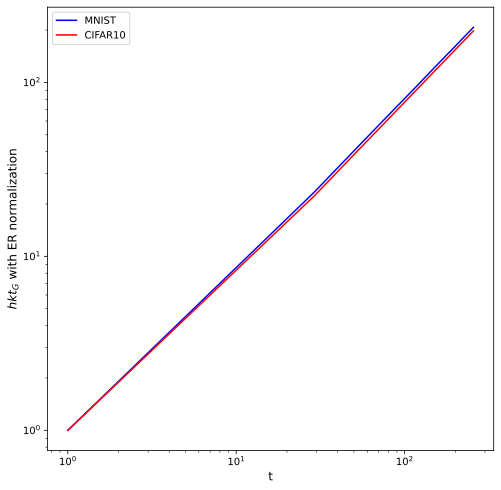

In [131]:
plt.figure(figsize=(8, 8))
plt.plot(t_arr, mnist_hkt, color='blue', label='MNIST')
plt.plot(t_arr, cifar_hkt, color='red', label='CIFAR10')
plt.legend()
plt.ylabel(r"$hkt_G$ with ER normalization", size=12)
plt.xlabel('t', size=12)
plt.yscale('log')
plt.xscale('log')

plt.show()